# Setup

In [1]:
# Used to read .env files, for access tokens and other secrets or configurations
%load_ext dotenv
%dotenv
import os

In [2]:
from github import Github
import pandas
from matplotlib import pyplot
import numpy

from datetime import datetime, timedelta

In [3]:
# The github token is stored in a .env file next to this notebook in the form "GITHUB_TOKEN = <your token here>"
g = Github(os.getenv("GITHUB_TOKEN"))

repo = g.get_repo('bpmn-io/bpmn-js')
print(repo)

Repository(full_name="bpmn-io/bpmn-js")


### Team Constants

These are things that describe how the team work and are static

In [4]:
# In the following, we will asume that sprints are totally regular, starting with a fixed date.
# The helper functions can of course be adapted to represent, e.g., changes in sprint duration or holiday breaks

start_date_first_sprint = datetime(2018, 11, 5) # It's a monday
sprint_length = timedelta(weeks=2)

def date_to_sprint(date_to_convert):
    return max(0, (date_to_convert - start_date_first_sprint) // sprint_length + 1) # Sprint "0" is everything before the first

def sprint_to_start_date(sprint_to_convert):
    return start_date_first_sprint + (sprint_to_convert - 1) * sprint_length

# Data Collection and Preprocessing

In [5]:
issues_raw = repo.get_issues(state='all')

In [6]:
attributes = ['number', 'title', 'labels', 'created_at', 'closed_at']
issues_dataframe = pandas.DataFrame([[getattr(issue, attr) for attr in attributes] for issue in issues_raw], columns=attributes)
issues_dataframe

,number,title,labels,created_at,closed_at
0,1748,deps: update dependency tiny-svg to v3 - autoc...,"[Label(name=""dependencies"")]",2022-09-29 22:06:43,2022-09-30 08:06:11
1,1747,deps: update dependency min-dom to v4,"[Label(name=""dependencies"")]",2022-09-29 21:23:31,2022-09-29 21:51:18
2,1746,deps: update dependency min-dash to v4,"[Label(name=""dependencies"")]",2022-09-29 21:23:00,2022-09-29 22:05:16
3,1745,deps: update dependency diagram-js to v9 - aut...,"[Label(name=""dependencies"")]",2022-09-29 20:34:50,2022-09-30 08:06:09
4,1744,chore: update dependency eslint-plugin-bpmn-io...,"[Label(name=""dependencies"")]",2022-09-29 20:34:15,2022-09-30 07:16:16
...,...,...,...,...,...
1736,5,1st Release,[],2014-03-20 10:06:23,2014-03-20 10:06:51
1737,4,I can create a new process,[],2014-03-19 14:36:22,2014-07-07 08:14:41
1738,3,I can open a simple BPMN 2.0 process,"[Label(name=""rendering"")]",2014-03-19 08:35:02,2019-06-13 12:39:37
1739,2,I can drag and drop BPMN elements in a process,[],2014-03-14 10:57:50,2014-08-04 10:47:11


In [7]:
issues_opened_per_sprint = issues_dataframe.groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index]['created_at'])))['number'].count().astype('Int64')
issues_closed_per_sprint = issues_dataframe[issues_dataframe.closed_at.notnull()].groupby(by=(lambda index: date_to_sprint(issues_dataframe.loc[index]['closed_at'])))['number'].count().astype('Int64')

In [8]:
issues = pandas.DataFrame(index=range(0, date_to_sprint(datetime.today()))) # The range ensures that there are rows for sprints where no issues were opened or closed
issues = pandas.concat([issues, issues_opened_per_sprint, issues_closed_per_sprint], axis='columns')
issues.index.name = 'sprint'
issues.columns = ['opened', 'closed']
issues = issues.fillna(0) # Replace NaN values from outer join with zero
# issues

In [9]:
issues['open_at_start'] = 0
for sprint in range(1, max(issues.index)+1):
    issues.open_at_start[sprint] = issues.open_at_start[sprint-1] + issues.opened[sprint-1] - issues.closed[sprint-1]
issues

/mnt/d/Users/Leon Bein/Documents/HPI/U_Masterarbeit/masterThesisCode/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,opened,closed,open_at_start
sprint,,,
0,894,831,0
1,11,7,63
2,13,8,67
3,6,3,72
4,3,1,75
...,...,...,...
98,2,1,93
99,22,25,94
100,9,6,91


# Analyze

In [10]:
start_sprint = date_to_sprint(datetime(2022, 6, 1)) # Using date here to be able to explore sprint length
end_sprint = date_to_sprint(datetime(2022, 10, 1))

In [11]:
issues_focus = issues[(issues.index >= start_sprint) & (issues.index <= end_sprint)]
issues_focus

,opened,closed,open_at_start
sprint,,,
94,13,10,87
95,4,2,90
96,7,6,92
97,5,5,93
98,2,1,93
99,22,25,94
100,9,6,91
101,4,2,94
102,9,14,96


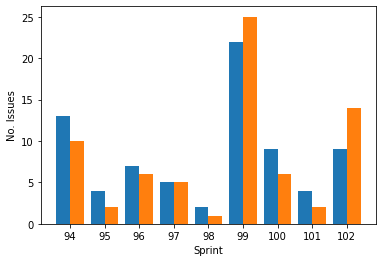

In [13]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2, issues_focus['opened'], width=0.4)
#pyplot.bar(issues_focus.index, issues_focus['closed'], bottom=issues_focus['opened'])
pyplot.bar(issues_focus.index+0.2, issues_focus['closed'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
print() # silence output from command before

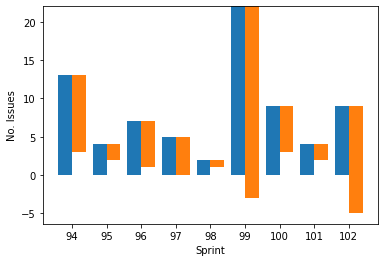

In [14]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2, issues_focus['opened'], width=0.4)
#pyplot.bar(issues_focus.index, issues_focus['closed'], bottom=issues_focus['opened'])
pyplot.bar(issues_focus.index+0.2, -issues_focus['closed'], bottom=issues_focus['opened'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
print() # silence output from command before

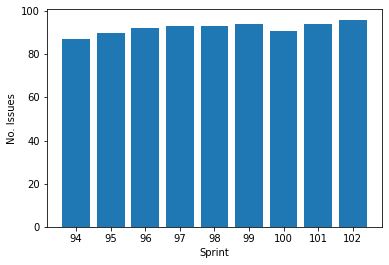

In [15]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['open_at_start'])
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
print() # silence output from command before

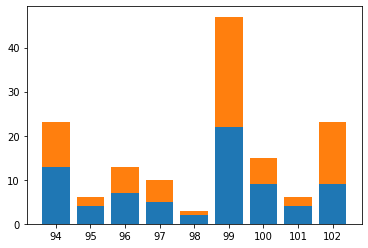

In [19]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['opened'])
pyplot.bar(issues_focus.index, issues_focus['closed'], bottom=issues_focus['opened'])
axes.set_xticks(issues_focus.index)
print() # silence output from command before